In [1]:
import sys
from PIL import Image
sys.path.append("D:\Python_Projects\PhD_project")
import importlib
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, models, transforms
import torchvision
from visualDet3D.visualDet3D.data.kitti.utils import write_result_to_file
from visualDet3D.visualDet3D.utils.utils import LossLogger, cfg_from_file
from visualDet3D.visualDet3D.networks.utils.registry import DETECTOR_DICT, DATASET_DICT, PIPELINE_DICT
from visualDet3D.visualDet3D.networks.heads.anchors import Anchors
from visualDet3D.visualDet3D.networks.lib.fast_utils.hill_climbing import post_opt
from visualDet3D.visualDet3D.networks.utils import BBox3dProjector, BackProjection
from visualDet3D.visualDet3D.utils.utils import convertAlpha2Rot, convertRot2Alpha, draw_3D_box, compound_annotation
#from visualDet3D.visualDet3D.data.kitti.dataset import *
import visualDet3D.visualDet3D.data.kitti.dataset
from visualDet3D.visualDet3D.utils.timer import Timer
from numba import jit
from tqdm import tqdm
print('CUDA available: {}'.format(torch.cuda.is_available()))

cfg = cfg_from_file('D:/Python_Projects/PhD_project/visualDet3D/config/config.py')
is_test_train = True

checkpoint_name = 'D:/Python_Projects/PhD_project/visualDet3D/workdirs/Mono3D/checkpoint/GroundAware_pretrained.pth'

CUDA available: True


In [2]:
def draw_bbox2d_to_image(image, bboxes2d, color=(255, 0, 255)):
    drawed_image = image.copy()
    for box2d in bboxes2d:
        cv2.rectangle(drawed_image, (int(box2d[0]), int(box2d[1])), (int(box2d[2]), int(box2d[3])), color, 3)
    return drawed_image

In [3]:
detector = DETECTOR_DICT[cfg.detector.name](cfg.detector)
detector = detector.cuda()

weight_path = os.path.join(cfg.path.checkpoint_path, checkpoint_name)
state_dict = torch.load(weight_path, map_location='cuda:{}'.format(cfg.trainer.gpu))
new_dict = state_dict.copy()
for key in state_dict:
    if 'focalLoss' in key:
        new_dict.pop(key)
detector.load_state_dict(new_dict, strict=False)
detector.eval().cuda()

# testing pipeline
test_func = PIPELINE_DICT[cfg.trainer.test_func]

projector = BBox3dProjector().cuda()
backprojector = BackProjection().cuda()

In [4]:
from torchvision import transforms

input_image = Image.open('D:/Python_Projects/self_driving_car/nuscenes-devkit/python-sdk/nuscenes/visualDet3D/data/testing/image_2/000001.png')
image = np.array(input_image)
calib = dict()
path = 'D:/Python_Projects/self_driving_car/nuscenes-devkit/python-sdk/nuscenes/visualDet3D/data/testing/calib/000001.txt'
with open(path) as f:
    str_list = f.readlines()
str_list = [itm.rstrip() for itm in str_list if itm != '\n']
for itm in str_list:
    calib[itm.split(':')[0]] = itm.split(':')[1]
for k, v in calib.items():
    calib[k] = [float(itm) for itm in v.split()]
calibr = np.array(calib['P2']).reshape(3,4)


def collate_fn(batch):
    rgb_images = np.array([item["image"] for item in batch]) #[batch, H, W, 3]
    rgb_images = rgb_images.transpose([0, 3, 1, 2])
    calib = np.array([item["calib"] for item in batch])
    return torch.from_numpy(rgb_images).float(), torch.from_numpy(calib).float()



In [5]:
def corner_homo2bbox(corner_homo):
    """
        corner_homo: [N, 8, 3]
    """
    min_xy  = torch.min(corner_homo[:, :, 0:2], dim=1)[0]
    max_xy  = torch.max(corner_homo[:, :, 0:2], dim=1)[0]
    min_xy[:, 0]  = torch.clamp(min_xy[:, 0], 0, cfg.rgb_shape[1])
    min_xy[:, 1]  = torch.clamp(min_xy[:, 1], 0, cfg.rgb_shape[0])
    max_xy[:, 0]  = torch.clamp(max_xy[:, 0], 0, cfg.rgb_shape[1])
    max_xy[:, 1]  = torch.clamp(max_xy[:, 1], 0, cfg.rgb_shape[0])
    return torch.cat([min_xy, max_xy], dim=1)

def denorm(image):
    new_image = np.array((image * cfg.data.augmentation.rgb_std +  cfg.data.augmentation.rgb_mean) * 255, dtype=np.uint8)
    return new_image

@jit(cache=True, nopython=True)
def ToColorDepth(depth_image:np.ndarray)->np.ndarray: #[H, W] -> [H, W, 3] # Used to draw depth predictions
    H, W = depth_image.shape
    max_depth = float(np.max(depth_image))
    cmap = np.array([
        [0,0,0,114],[0,0,1,185],[1,0,0,114],[1,0,1,174], 
        [0,1,0,114],[0,1,1,185],[1,1,0,114],[1,1,1,0]
    ])
    _sum  = 0
    for i in range(8):
        _sum += cmap[i, 3]
    
    weights = np.zeros(8)
    cumsum = np.zeros(8)
    for i in range(7):
        weights[i] = _sum / cmap[i, 3]
        cumsum[i+1] = cumsum[i] + cmap[i, 3] / _sum
    
    image = np.zeros((H, W, 3), dtype=np.uint8)
    for i in range(H):
        for j in range(W):
            val = depth_image[i, j] / max_depth
            for k in range(7):
                if val <= cumsum[k + 1]:
                    break
            w = 1.0- (val - cumsum[k]) * weights[k]
            r = int( (w * cmap[k, 0] + (1 - w) * cmap[k+1, 0]) * 255 )
            g = int( (w * cmap[k, 1] + (1 - w) * cmap[k+1, 1]) * 255 )
            b = int( (w * cmap[k, 2] + (1 - w) * cmap[k+1, 2]) * 255 )
            image[i, j] = np.array([r,g,b])
    return image

In [6]:
from visualDet3D.visualDet3D.data.pipeline import build_augmentator
def compute_once(is_draw=True, is_test_train=True):
    transform = build_augmentator(cfg.data.test_augmentation)
    transformed_image, transformed_P2 = transform(image.copy(), p2=calibr.copy())
    data = {'calib': transformed_P2,
                       'image': transformed_image,
                       'original_shape':image.shape,
                       'original_P':calibr.copy()}
    
    original_height = data['original_shape'][0]
    collated_data = collate_fn([data])

    transformed_image = collated_data[0]
    transformed_P2 = collated_data[1]
    
    height = collated_data[0].shape[2]
    scale_2d = (original_height - cfg.data.augmentation.crop_top) / height
    
    test_func = PIPELINE_DICT[cfg.trainer.test_func]
    with torch.no_grad():
        scores, bbox, obj_names = test_func(collated_data, detector, None, cfg=cfg)       
        transformed_P2 = transformed_P2[0] 
        bbox_2d = bbox[:, 0:4]
        bbox_3d_state = bbox[:, 4:] #[cx,cy,z,w,h,l,alpha]
        bbox_3d_state_3d = backprojector(bbox_3d_state, transformed_P2.cuda()) #[x, y, z, w,h ,l, alpha]
        abs_bbox, bbox_3d_corner_homo, thetas = projector(bbox_3d_state_3d, transformed_P2.cuda())
          
    rgb_image = denorm(transformed_image[0].cpu().numpy().transpose([1, 2, 0]))
    if len(scores) > 0:
        rgb_image = draw_bbox2d_to_image(rgb_image, bbox_2d.cpu().numpy())
        for box in bbox_3d_corner_homo:
            box = box.cpu().numpy().T
            rgb_image = draw_3D_box(rgb_image, box)
    if is_draw:
        plt.imshow(np.clip(rgb_image, 0, 255))

    objects = []
    N = len(bbox)
    for i in range(N):
        obj = {}
        obj['whl'] = bbox_3d_state_3d[i, 3:6]
        obj['theta'] = thetas[i]
        obj['score'] = scores[i]
        obj['type_name'] = obj_names[i]
        obj['xyz'] = bbox_3d_state_3d[i, 0:3]
        objects.append(obj)
    print(objects) 

    return np.clip(rgb_image, 0, 255)

```python
centers = np.array([[1.50, 1.57, 1.625, 1.67, 1.72],
                    [1.42, 1.46,  1.50, 1.58, 1.66],
                    [3.43, 3.63,  3.89, 4.17, 4.47]]) #[3, 5]
```

[{'whl': tensor([1.6292, 1.5660, 4.5354], device='cuda:0'), 'theta': tensor(-0.2489, device='cuda:0'), 'score': tensor(0.9961, device='cuda:0'), 'type_name': 'Car', 'xyz': tensor([-9.1681,  0.9484, 18.3366], device='cuda:0')}, {'whl': tensor([1.7288, 1.6186, 4.1517], device='cuda:0'), 'theta': tensor(0.7109, device='cuda:0'), 'score': tensor(0.9540, device='cuda:0'), 'type_name': 'Car', 'xyz': tensor([-8.2275,  0.7891, 11.9172], device='cuda:0')}]


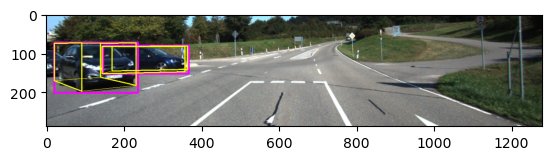

In [7]:
a = compute_once()

[{'whl': tensor([1.6292, 1.5660, 4.5354], device='cuda:0'), 'theta': tensor(-0.2489, device='cuda:0'), 'score': tensor(0.9961, device='cuda:0'), 'type_name': 'Car', 'xyz': tensor([-9.1681,  0.9484, 18.3366], device='cuda:0')}, {'whl': tensor([1.7288, 1.6186, 4.1517], device='cuda:0'), 'theta': tensor(0.7109, device='cuda:0'), 'score': tensor(0.9540, device='cuda:0'), 'type_name': 'Car', 'xyz': tensor([-8.2275,  0.7891, 11.9172], device='cuda:0')}]


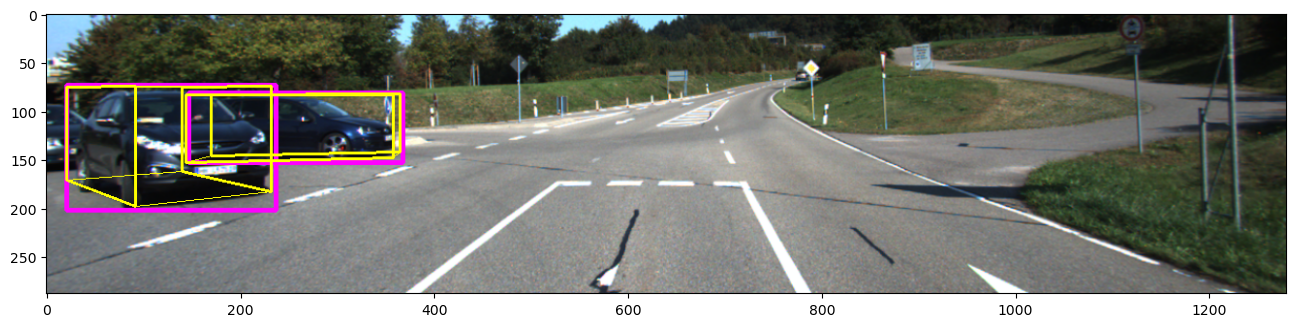

In [8]:
#%matplotlib inline
fig = plt.figure(figsize=(16,9))
a = compute_once(is_test_train=False, is_draw=True)

width-->x axis //
height-->y axis //
length-->z axis //
theta γωνια μεταξυ x-z (2D επιπεδο)